In [2]:
from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
#import statsmodels
#import statsmodels.api as sm
#from statsmodels.tsa.stattools import coint, adfuller
#from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
#from xml.etree import ElementTree as ET
#from IPython.core.debugger import set_trace
import seaborn as sns
import random


In [3]:
# Connect to IB Server
ib=IB()
util.startLoop()
ib.connect('127.0.0.1',7497, clientId= 55)

<IB connected to 127.0.0.1:7497 clientId=55>

In [4]:
#define a function to get IB data 
def get_data(contract, history, freq, side):
    
    bar = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr=history,
        barSizeSetting= freq,
        whatToShow=side,
        useRTH=True,
        formatDate=1)
    
# use util in ib-insync to convert bar data into pandas dataframe    
    df = util.df(bar)
# return df 
    return df 


In [5]:
# find a stock contract and fully qualify it with all the attributes
ticker1 ='QQQ'
ticker2 = 'SPY'
ticker3 = 'DIA'

contract1 = Contract(symbol = ticker1, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract1)

contract2 = Contract(symbol = ticker2, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract2)

contract3 = Contract(symbol = ticker3, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract2)

[Contract(secType='STK', conId=756733, symbol='SPY', exchange='SMART', primaryExchange='ARCA', currency='USD', localSymbol='SPY', tradingClass='SPY')]

In [8]:
#get historical data
history = '1 Y'
freq = '1 day'
side ='Trades' # last trade, or ASK, or Bid

df1 = get_data(contract1, history, freq, side )
df2 = get_data(contract2, history, freq, side )
df3 = get_data(contract3, history, freq, side )

# form returns series by taking pct or log changes
# from pandas package 
# as well as numpy

df1[ticker1]= df1['close'].pct_change().dropna()
df2[ticker2]= df2['close'].pct_change().dropna()
df3[ticker3]= df3['close'].pct_change().dropna()

#thses are mean or expected returns for the three stocks, based on the 1-year daily data. 
u1 = df1[ticker1].mean()
u2 = df2[ticker2].mean()
u3 = df3[ticker3].mean()

df1.head() # to see what the top 5 rows look like


,date,open,high,low,close,volume,average,barCount,QQQ
0,2020-02-11,233.21,234.02,231.39,232.01,224361,232.8330,103838,NaN
1,2020-02-12,233.34,234.38,232.80,234.27,163908,233.6790,69637,0.009741
2,2020-02-13,232.62,234.93,232.36,233.97,182170,233.9465,77809,-0.001281
3,2020-02-14,234.28,234.86,233.55,234.64,151674,234.2145,63112,0.002864
4,2020-02-18,233.47,235.17,233.25,234.73,178255,234.2425,76014,0.000384


In [7]:
#Combine three return series into one pandas frame

df =pd.concat([df1[ticker1], df2[ticker2]], axis =1)
df = pd.concat([df, df3[ticker3]], axis =1).dropna()

#see what df looks like
df.head() # top 5 rows of df

,QQQ,SPY,DIA
1,0.009741,0.006443,0.009490
2,-0.001281,-0.001067,-0.003043
3,0.002864,0.001602,-0.000950
4,0.000384,-0.002577,-0.005398
5,0.009585,0.004781,0.003926


In [10]:
#finde covariance and correlation matrix

df_corr = df.corr()
df_cov = df.cov()

In [13]:
# Example of 


A = df_cov
wt = pd.DataFrame ([0.4, 0.2, 0.4])
wt.index =A.index
port_var = wt.T.dot(A.dot(wt))
# portfolio variance through matrix multiplication


$\Omega = df_{cov}$ 
is the covariance matrix 
$w = wt$ is the portfolio weight 
port_var = $\mathbf{w}^T\Omega \mathbf{w}$

In [14]:
# this function calculate the portoflio return and standard deviation for a given weight
def port(wt):
    
    cov_matrix = df_cov
    return_matrix = pd.DataFrame ([u1,u2,u3])
    
    return_matrix.index = cov_matrix.index
    
    wt.index = cov_matrix.index
    
    v = cov_matrix.dot(wt)
    u = return_matrix.T.dot(wt)
    
    port_var = wt.T.dot(v).values
    
    port_return = u.values
    
    
    return [port_return, port_var]

In [15]:
#simulate portfolio weights. You should try different ways of simulating to get a sense of how random module works in Python
#This is a very rudimentary simulation method.

ret =[] # portfolio returns
sig =[] # portfolio return volatility

n = 100
#number of simulation run
for i in range(n):
    
    w1= random.randint(0,n)
    
    for j in range (n):
    
        w2 = random.randint (0, n-w1)
    
        w3 = n-w1-w2
        
        wt = pd.DataFrame([w1/n, w2/n, w3/n])
        
        #print (wt)
        
        r = port (wt)[0]
        v = port (wt)[1]
        
        #print (r, v) 
        
        
        ret = np.append (ret, r)
        sig = np.append (sig, math.sqrt(v))


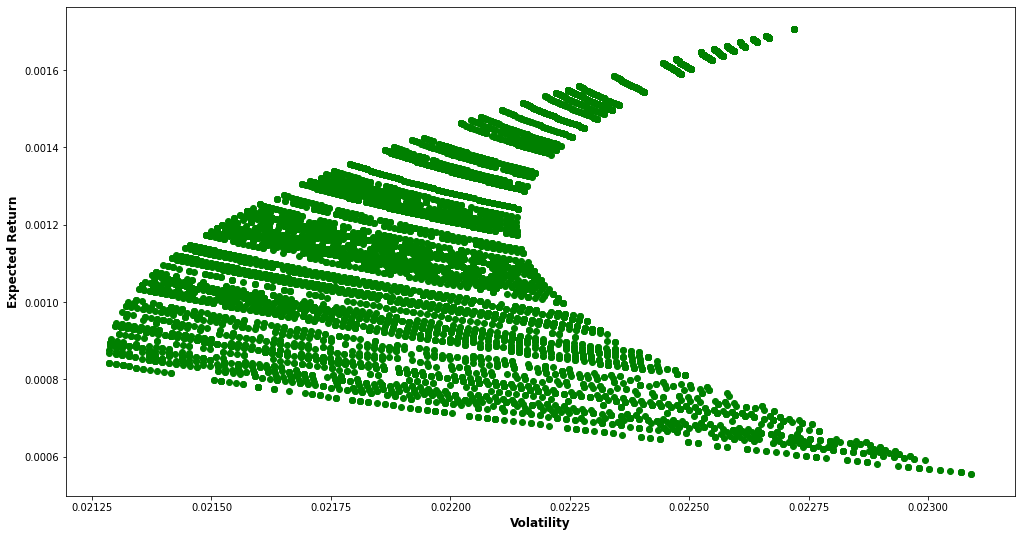

In [24]:
#Generate efficient frontier graph using Matplotlib libirary

plt.figure(figsize =[17,9])
plt.scatter(sig, ret, color ="green")
plt.xlabel("Volatility", fontsize='large', fontweight='bold')
plt.ylabel("Expected Return",fontsize='large', fontweight='bold')

plt.show()


$\textbf{Assigment:}$

1. Start learning basic Python for Finance at https://www.quantconnect.com/tutorials/tutorial-series/introduction-to-financial-python 
2. Assuming risk-free rate r_f = 0.0010, please add the tangent line (also call capital market line) to the graph using Matplotlib, also identiy the three stocks (JPM, APPL, XOM) with three dots on the capital market line 
3. Test to see if CAPM holds based on the 5-year historical data for these three stocks. This invoves running linear regression between daily JPM returns against S&P index (represented by SPY) returns, to see if this regression line is close enough to the capital market line. If different, please use longer history or differetn history to see if it imporve the result.

